In [1]:
# Connecter Google Drive et définir les chemins du jeu de données IRM/ITRM (Colab)
try:
    from google.colab import drive  # type: ignore
    drive.mount('/content/drive')
    import os
    # Tester plusieurs dossiers candidats pour s'adapter à votre structure Drive
    candidats = (
        'IRM',
        'ITRM',
        'Datasets/IRM',
    )
    DATASET_DIR = None
    for c in candidats:
        p = f"/content/drive/MyDrive/{c}"
        if os.path.isdir(p):
            DATASET_DIR = p
            break
    if DATASET_DIR is None:
        # Valeur par défaut: IRM si aucun dossier trouvé; adaptez si votre chemin Drive est différent
        DATASET_DIR = '/content/drive/MyDrive/IRM'
    TRAIN_DIR = os.path.join(DATASET_DIR, 'Training')
    TEST_DIR = os.path.join(DATASET_DIR, 'Testing')
    print('Drive monté.')
    print('DATASET_DIR =', DATASET_DIR)
    print('TRAIN_DIR   =', TRAIN_DIR)
    print('TEST_DIR    =', TEST_DIR)
except ModuleNotFoundError:
    # Exécution hors Colab (ex. local). Adaptez les chemins si nécessaire.
    import os
    DATASET_DIR = os.path.abspath('IRM')  # ou 'ITRM' si votre dossier local porte ce nom
    TRAIN_DIR = os.path.join(DATASET_DIR, 'Training')
    TEST_DIR = os.path.join(DATASET_DIR, 'Testing')
    print('Colab non détecté. Utilisation des chemins locaux.')
    print('DATASET_DIR =', DATASET_DIR)
    print('TRAIN_DIR   =', TRAIN_DIR)
    print('TEST_DIR    =', TEST_DIR)


Colab non détecté. Utilisation des chemins locaux.
DATASET_DIR = d:\Data driven\classification\TP_Classification_tumeur_CNN\IRM
TRAIN_DIR   = d:\Data driven\classification\TP_Classification_tumeur_CNN\IRM\Training
TEST_DIR    = d:\Data driven\classification\TP_Classification_tumeur_CNN\IRM\Testing


# Introduction

Dans ce notebook, nous allons construire un modèle basé sur un CNN pour classer des images IRM de tumeurs cérébrales.


In [2]:
# Importation des bibliothèques et des modules
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input
from tensorflow.keras.activations import relu
from sklearn.metrics import classification_report, confusion_matrix
import os
import cv2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import warnings 

# Masquer les avertissements
warnings.filterwarnings("ignore")


ModuleNotFoundError: No module named 'numpy'

In [ ]:
# Déterminer les répertoires du jeu de données (priorité à Google Drive IRM/ITRM si disponible)
try:
    training_file = TRAIN_DIR
    test_file = TEST_DIR
    print('Utilisation du jeu de données Google Drive :')
    print('  TRAIN_DIR =', training_file)
    print('  TEST_DIR  =', test_file)
except NameError:
    # Repli (fallback) vers le jeu de données Kaggle
    main_directory = "/kaggle/input/brain-tumor-classification-mri"
    training_file = os.path.join(main_directory, "Training")
    test_file = os.path.join(main_directory, "Testing")
    print('Utilisation du jeu de données Kaggle :')
    print('  TRAIN =', training_file)
    print('  TEST  =', test_file)


In [ ]:
# Validation rapide de la structure du jeu de données et des effectifs par classe
import os
from collections import Counter

assert os.path.isdir(training_file), f"Répertoire d'entraînement introuvable : {training_file}"
assert os.path.isdir(test_file), f"Répertoire de test introuvable : {test_file}"

train_classes = sorted([d for d in os.listdir(training_file) if os.path.isdir(os.path.join(training_file, d))])
test_classes = sorted([d for d in os.listdir(test_file) if os.path.isdir(os.path.join(test_file, d))])

print('Classes (train) :', train_classes)
print('Classes (test)  :', test_classes)

# Vérifier que les classes sont identiques entre train et test
if train_classes != test_classes:
    print('\n[Avertissement] Les dossiers de classes Train/Test diffèrent !')

# Compter le nombre d'images par classe (train et test)

def compter_images(base):
    comptes = {}
    for c in train_classes:
        p = os.path.join(base, c)
        if os.path.isdir(p):
            comptes[c] = sum(1 for _ in os.scandir(p) if _.is_file())
    return comptes

train_counts = compter_images(training_file)
test_counts = compter_images(test_file)
print('\nNombre d\'images par classe (train) :', train_counts)
print('Nombre d\'images par classe (test)  :', test_counts)


In [ ]:
# Spécifier les classes dans le jeu d'entraînement
labels = os.listdir(training_file)
print("Classes :", labels)


Classes: ['no_tumor', 'pituitary_tumor', 'meningioma_tumor', 'glioma_tumor']


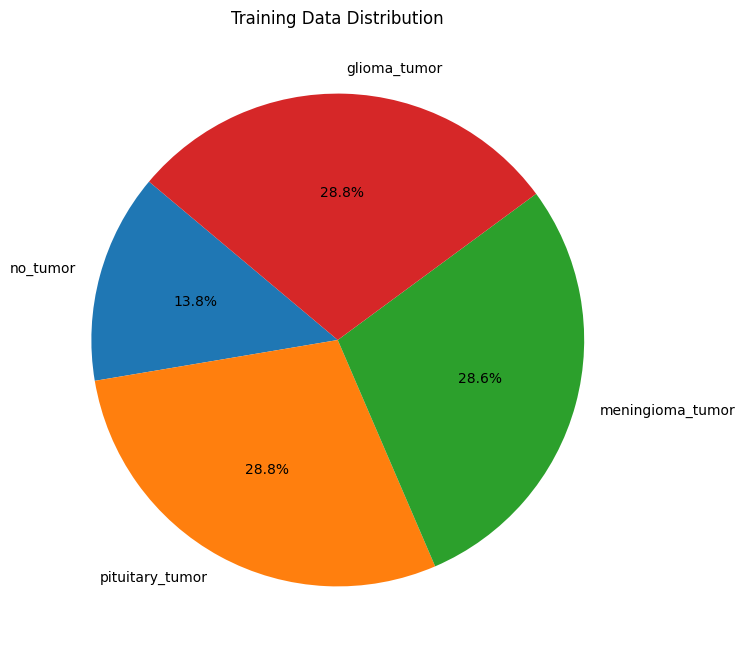

In [ ]:
# Analyser les données et visualiser leurs caractéristiques
label_counts = {label: len(os.listdir(os.path.join(training_file, label))) for label in labels}

# Visualiser avec un diagramme circulaire
plt.figure(figsize=(8, 8))
plt.pie(label_counts.values(), labels=label_counts.keys(), autopct='%1.1f%%', startangle=140)
plt.title("Répartition des données d'entraînement")
plt.show()


In [ ]:
# Maintenant que nous voyons la répartition, ajustons la taille des images et entraînons le modèle

# Opérations d'augmentation de données
data_augment = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.15,
    rotation_range=30,
    width_shift_range=0.25,
    height_shift_range=0.25,
    shear_range=0.25,
    zoom_range=0.25,
    horizontal_flip=True,
    fill_mode='nearest'
)

training_generate = data_augment.flow_from_directory(
    training_file,
    target_size=(150, 150),
    batch_size= 64,
    class_mode='categorical',
    subset='training'
)
validate_and_generate = data_augment.flow_from_directory(
    training_file,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)


Found 2441 images belonging to 4 classes.
Found 429 images belonging to 4 classes.


In [ ]:
# Préparer le générateur de test (sans augmentation)
from tensorflow.keras.preprocessing.image import ImageDataGenerator

test_datagen = ImageDataGenerator(rescale=1./255)

# Imposer l'ordre des classes pour correspondre à l'entraînement (reporting cohérent)
test_generate = test_datagen.flow_from_directory(
    test_file,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False,  # important pour conserver l'ordre de y_true
    classes=labels  # assure que l'ordre des classes correspond à l'entraînement
)


In [ ]:
# Créer le modèle CNN pour la classification

CNN_model = Sequential([
    Input(shape=(150, 150, 3)),

    # Premier bloc de convolution
    Conv2D(32, (3,3), activation=relu, padding='same'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    # Deuxième bloc de convolution
    Conv2D(64, (3,3), activation=relu, padding='same'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    # Troisième bloc de convolution
    Conv2D(128, (3,3), activation=relu, padding='same'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    # Quatrième bloc de convolution
    Conv2D(256, (3,3), activation=relu, padding='same'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    # Cinquième bloc de convolution (couche additionnelle)
    Conv2D(512, (3,3), activation=relu, padding='same'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    # Global Average Pooling (pour un apprentissage plus efficace)
    GlobalAveragePooling2D(),

    # Couches entièrement connectées (Dense)
    Dense(512, activation=relu),
    Dropout(0.5),  # Dropout pour limiter le sur-apprentissage (overfitting)
    Dense(256, activation=relu),
    Dropout(0.3),

    # Couche de sortie (classification avec Softmax)
    Dense(len(labels), activation='softmax')
])

# Afficher le résumé du modèle
CNN_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 150, 150, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 150, 150, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 75, 75, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 75, 75, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 75, 75, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 37, 37, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 37, 37, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 37, 37, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 18, 18, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 18, 18, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 18, 18, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 9, 9, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 9, 9, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 9, 9, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 1,967,556 (7.51 MB)

 Trainable params: 1,965,572 (7.50 MB)

 Non-trainable params: 1,984 (7.75 KB)

In [ ]:
# Compiler et entraîner le modèle
from tensorflow.keras.callbacks import ModelCheckpoint

optimizer = Adam(learning_rate = 0.0005)  # Apprentissage plus rapide

# Callback pour sauvegarder le meilleur modèle sur Drive
checkpoint = ModelCheckpoint(
    filepath=os.path.join(DATASET_DIR, 'best_cnn_model.h5'),
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1)

epoch_count = 30  # Plus d'époques pour une meilleure convergence
batch_size = 64   # Batch plus grand pour une meilleure estimation du gradient
fitness = CNN_model.fit(
    training_generate,
    validation_data=validate_and_generate,
    epochs=epoch_count,
    batch_size=batch_size,
    callbacks=[checkpoint, reduce_lr, early_stop],  # Ajout du checkpoint
    verbose=1,
)


Epoch 1/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 175s 4s/step - accuracy: 0.3670 - loss: 1.4779 - val_accuracy: 0.2867 - val_loss: 1.3741 - learning_rate: 1.0000e-04
Epoch 2/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 167s 4s/step - accuracy: 0.5592 - loss: 1.0322 - val_accuracy: 0.2890 - val_loss: 1.3930 - learning_rate: 1.0000e-04
Epoch 3/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 167s 4s/step - accuracy: 0.6318 - loss: 0.9167 - val_accuracy: 0.2890 - val_loss: 1.6761 - learning_rate: 1.0000e-04
Epoch 4/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6404 - loss: 0.8443
Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
39/39 ━━━━━━━━━━━━━━━━━━━━ 167s 4s/step - accuracy: 0.6405 - loss: 0.8440 - val_accuracy: 0.2890 - val_loss: 2.6678 - learning_rate: 1.0000e-04
Epoch 5/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 204s 4s/step - accuracy: 0.6959 - loss: 0.7226 - val_accuracy: 0.2890 - val_loss: 3.6841 - learning_rate: 5.0000e-05
Epoch 6/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 201s 4s/step - accuracy: 0.7145 - loss:

In [ ]:
# Évaluer sur le jeu de test
print("\nÉvaluation sur le jeu de test...")
try:
    test_loss, test_acc = CNN_model.evaluate(test_generate, verbose=1)
    print(f"Perte (test) : {test_loss:.4f}\nPrécision (test) : {test_acc:.4f}")
except NameError as e:
    print("Échec de l'évaluation : assurez-vous que test_generate est défini et que le modèle est entraîné.")
    raise


In [ ]:
# Rapport de classification et matrice de confusion
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Prédire les probabilités sur le jeu de test
preds = CNN_model.predict(test_generate, verbose=1)
y_pred = np.argmax(preds, axis=1)

# Étiquettes vraies et noms de classes
y_true = test_generate.classes
class_labels = list(labels)  # utiliser le même ordre que l'entraînement

# Rapport texte
print("\nRapport de classification (Test) :\n")
print(classification_report(y_true, y_pred, target_names=class_labels, digits=4))

# Matrice de confusion
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Matrice de confusion - Jeu de test')
plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.tight_layout()
plt.show()


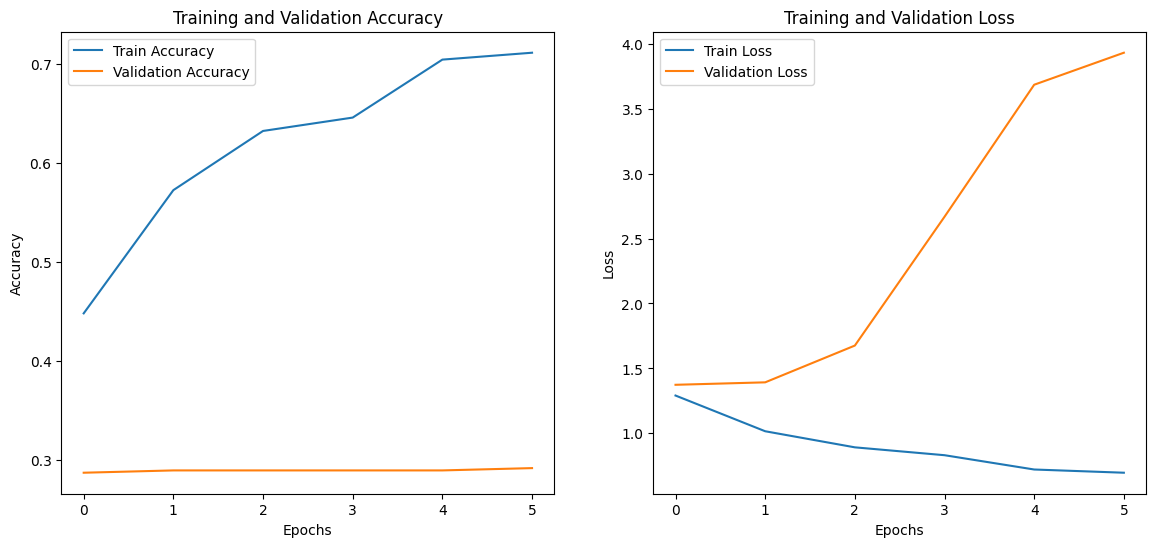

In [ ]:
# Visualiser les courbes d'entraînement et de validation
fig, ax = plt.subplots(1, 2, figsize = (14, 6))
ax[0].plot(fitness.history["accuracy"], label = "Précision (train)")
ax[0].plot(fitness.history['val_accuracy'], label='Précision (validation)')
ax[0].set_xlabel('Époques')
ax[0].set_ylabel('Précision')
ax[0].set_title('Précision - Entraînement vs Validation')
ax[0].legend()

# Tracer la fonction de perte
ax[1].plot(fitness.history['loss'], label='Perte (train)')
ax[1].plot(fitness.history['val_loss'], label='Perte (validation)')
ax[1].set_xlabel('Époques')
ax[1].set_ylabel('Perte')
ax[1].set_title('Perte - Entraînement vs Validation')
ax[1].legend()
